In [ ]:
!pip install gradio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Project_2_Major(Deep Learning)/Vegetable_detection")

In [ ]:
!dir

#Step 1: Importing all the packages

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools
import tensorflow as tf

print("Tensorlfow Version: ", tf.__version__)
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

Tensorlfow Version:  2.15.0


In [ ]:
# !pip install patool
# import patoolib
# patoolib.extract_archive("Vegetable_Images.rar")
# patoolib.extract_archive("test_examples.rar")

In [ ]:
CLASSES = ["Bean", "Bitter_Gourd", "Bottle_Gourd", "Brinjal", "Broccoli", "Cabbage", "Capsicum", "Carrot",
           "Cauliflower", "Cucumber", "Papaya", "Potato", "Pumpkin", "Radish", "Tomato"]

DATASET = "vgg_dataset"  # this folder must contain 15 subfolder with images
MODEL = "vgg_16_scene.model" # name to store the model on disk
PLOT = "vgg_plot.png" # plot name

# set the batch size when fine-tuning
BATCH_SIZE = 32

INIT_LR = 1e-3

In [ ]:
trainPath = r"/content/drive/MyDrive/Project_2_Major(Deep Learning)/Vegetable_detection/Vegetable Images/train"
testPath =  r"/content/drive/MyDrive/Project_2_Major(Deep Learning)/Vegetable_detection/Vegetable Images/test"

In [ ]:
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(trainPath)))
totalTest = len(list(paths.list_images(testPath)))
print(totalTrain)
print(totalTest)

18000
720


In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [ ]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
    trainPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE)


# initialize the testing generator
testGen = valAug.flow_from_directory(
    testPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

Found 18000 images belonging to 15 classes.
Found 720 images belonging to 15 classes.


In [ ]:
baseModel = VGG16(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3))) #In this include_top=false beacuse baseModel download only CNN part of VGG16 model

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(4092, activation="relu")(headModel) #ReLu=max(0,n)
headModel = Dense(4092, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
vgg_model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
opt = SGD(learning_rate=1e-4, momentum=0.9)
vgg_model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = vgg_model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=testGen,
    validation_steps=totalTest // BATCH_SIZE,
    epochs=20)

print("[INFO] serializing network...")
vgg_model.save("vgg_model_20epochs.model", save_format="h5")

[INFO] training head...
Epoch 1/20
562/562 [==============================] - 326s 562ms/step - loss: 1.0731 - accuracy: 0.8872 - val_loss: 0.0753 - val_accuracy: 0.9872
Epoch 2/20
562/562 [==============================] - 310s 550ms/step - loss: 0.2230 - accuracy: 0.9624 - val_loss: 0.0823 - val_accuracy: 0.9901
Epoch 3/20
562/562 [==============================] - 312s 555ms/step - loss: 0.1388 - accuracy: 0.9755 - val_loss: 0.0242 - val_accuracy: 0.9943
Epoch 4/20
562/562 [==============================] - 311s 553ms/step - loss: 0.1168 - accuracy: 0.9785 - val_loss: 0.0520 - val_accuracy: 0.9915
Epoch 5/20
562/562 [==============================] - 317s 563ms/step - loss: 0.0882 - accuracy: 0.9829 - val_loss: 0.0156 - val_accuracy: 0.9972
Epoch 6/20
562/562 [==============================] - 314s 558ms/step - loss: 0.0746 - accuracy: 0.9855 - val_loss: 0.0071 - val_accuracy: 0.9986
Epoch 7/20
562/562 [==============================] - 312s 556ms/step - loss: 0.0560 - accuracy: 0.9

In [ ]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
from tensorflow.keras.models import load_model
vgg_model2 = load_model("vgg_model_20epochs.model")

print("[INFO] evaluating after fine-tuning network head...")
testGen.reset()
predIdxs = vgg_model2.predict(x=testGen,
    steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)

[INFO] evaluating after fine-tuning network head...
23/23 [==============================] - 4s 165ms/step


In [ ]:
def plot_acc(H, N, plotPath=None):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower left")
    plt.savefig("acc_output.png")

def plot_loss(H, N, plotPath=None):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")

    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.savefig("loss_output.png")

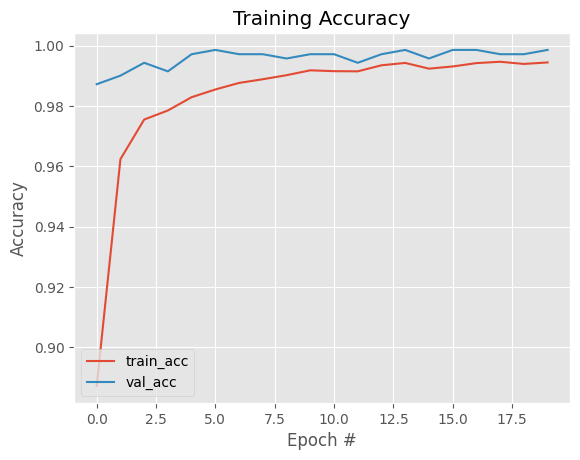

In [ ]:
# plot training and val accuracy
plot_acc(H, 20)

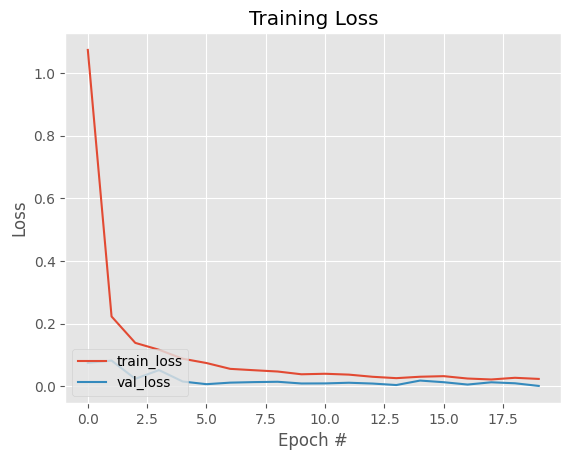

In [ ]:
# plot training and val loss
plot_loss(H, 20)

#Inference on Unseen Data

In [ ]:
import imutils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    # plt.grid(b=None)
    ax = fig.add_subplot(111)
    ax.imshow(img)

In [ ]:
!dir

acc_output.png	 test_examples			       Vegetable\ Images
loss_output.png  test_examples.rar		       Vegetable_Images.rar
test		 Vegetable_classification_VGG16.ipynb  vgg_model_20epochs.model


In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
import pickle
import cv2

# # load the model
print("[INFO] loading network and...")
model = load_model("vgg_model_20epochs.model")

# grab the image paths and randomly shuffle themt
testImagePaths = sorted(list(paths.list_images('test_examples')))   # data folder with 2 categorical folders


# progress bar
with tqdm(total=len(testImagePaths)) as pbar:

    for imagePath in testImagePaths:

        image = cv2.imread(imagePath)
        output = image.copy()
        output = imutils.resize(output, width=400)

        # our model was trained on RGB ordered images but OpenCV represents
        # images in BGR order, so swap the channels, and then resize to
        # 224x224 (the input dimensions for VGG16)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        # convert the image to a floating point data type and perform mean
        # subtraction
        image = image.astype("float32")
        mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
        image -= mean


        # pass the image through the network to obtain our predictions
        preds = model.predict(np.expand_dims(image, axis=0))[0]
        i = np.argmax(preds)
        label = CLASSES[i]

        # draw the prediction on the output image
        text = "{}: {:.2f}%".format(label, preds[i] * 100)
        cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
            (0, 255, 0), 2)

         # convert img to rgb format and display in notebook
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)

        pbar.update(1)


Output hidden; open in https://colab.research.google.com to view.

#Step 7:Saving the Model

In [ ]:
# save the model and label binarizer to disk
print("[INFO] serializing network and label binarizer...")
model.save('model_CNN.h5')

[INFO] serializing network and label binarizer...


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from imutils import paths
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    #plt.grid(b=None)
    ax = fig.add_subplot(111)

    ax.imshow(img)

In [ ]:
from tqdm import tqdm

#Deployment

In [ ]:
import gradio as gr
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Assume that you have a model variable defined somewhere with your trained model
# For example, you can load a pre-trained model like this:
# from tensorflow.keras.models import load_model
# model = load_model("your_model_path.h5")

# Create an Image input
im = gr.Image(image_mode="RGB")
label = gr.Label(num_top_classes=3)

# Define your classes
CLASSES = ["Bean", "Bitter_Gourd", "Bottle_Gourd", "Brinjal", "Broccoli", "Cabbage", "Capsicum", "Carrot",
           "Cauliflower", "Cucumber", "Papaya", "Potato", "Pumpkin", "Radish", "Tomato"]

def predict_image(image):
    # pre-process the image for classification
    image = cv2.resize(image, (224, 224))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    preds = model.predict(image)[0]

    # Create a dictionary to store class predictions
    result = {class_name: round(float(pred), 3) for class_name, pred in zip(CLASSES, preds)}

    print(result)

    return result

# Create Gradio interface
iface = gr.Interface(fn=predict_image, inputs=im, outputs=label, title="VGG16_Model")
iface.launch(share=True)
